In [52]:
import matplotlib.image as img
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.python.framework import ops
import math
import os
import keras
from keras import layers
from keras.layers import Dropout,Input, SeparableConv2D, Cropping2D,merge,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Lambda,Convolution2D,Conv2DTranspose,UpSampling2D,Subtract,regularizers
from keras.models import Model, load_model,Sequential
from keras.layers.merge import concatenate
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import SGD
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
import scipy.misc
import h5py
import matplotlib.image as img
from keras.callbacks import ModelCheckpoint,CSVLogger, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import Adam
import cv2, datetime,sys,glob
#os.environ['KERAS_BACKEND']= 'theano'
import keras.backend as K
from keras.utils import multi_gpu_model
use_gpu_num = 3
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from keras.models import *
from keras.layers import *
from keras.utils import plot_model
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

In [53]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [54]:

def Gender_model(input_shape=(116, 96, 3)):#facebc966
    imginputs = Input(shape=input_shape,name="img_inputs")  
    res=Conv2D(8, (3,3),strides=2,padding="same")(imginputs)
    res = Activation("relu")(res)
    res = SeparableConv2D(16, (3,3),strides=2,padding="same")(res)
    res = Activation('relu')(res)
    res = SeparableConv2D(32, (3,3),strides=1,padding="valid")(res)
    res = Activation('relu')(res)
    res = MaxPooling2D(pool_size=(2,2),strides = 4, padding="same")(res)
#     res = Dropout(0.2)(res)
    res0 = res
    res = SeparableConv2D(32, (3,3),strides=1,padding="same")(res)
    res = Activation('relu')(res)
    res = Add()([res, res0])
    res0 = res
    res = SeparableConv2D(32, (3,3),strides=1,padding="same")(res)
    res = Activation('relu')(res)
    res = Add()([res, res0])
    res0 = res
    res = SeparableConv2D(32, (3,3),strides=1,padding="same")(res)
    res = Activation('relu')(res)
    res = Add()([res, res0])
    res0 = res
    res = SeparableConv2D(32, (3,3),strides=1,padding="same")(res)
    res = Activation('relu')(res)
    res = Add()([res, res0])
    res0 = res
    res = SeparableConv2D(32, (3,3),strides=1,padding="same")(res)
    res = Activation('relu')(res)
    res = Flatten()(res)
    res = Dense(32, activation = "relu", use_bias = True)(res)
#     res = Dropout(0.85)(res)
    res = Dense(8, activation = "relu", use_bias = True)(res)
    res = Dense(1, activation = "sigmoid", use_bias = False)(res)
    print("res shape: ", str(res.shape))
    model = Model(inputs=[imginputs], outputs=res)
    return model



In [55]:
def step_decay(epoch):
    initial_lr = 1e-3
    if epoch < 100:
        lr = initial_lr
    elif epoch < 200:
        lr = initial_lr / 2
    elif epoch < 400:
        lr = initial_lr / 5
    else:
        lr = initial_lr/ 7
#     lr = 0.001
    return lr
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def input_data():
    path_x = "data/train/genderdata1/"
    train_num = 872#sum([len(x) for _, _, x in os.walk(os.path.dirname())])  
    print("train_num: ", train_num)
    dsize = 96
    image_train = np.zeros((train_num,116,96,3)) 
    label_train = np.zeros((train_num)) 
    for i in range(0,428):
        #print("label_train value:",str(label_train[i]))
        img = image.load_img(path_x + str(i) + ".bmp", target_size = (116,96))
        x = image.img_to_array(img)
        gray = rgb2gray(x)
        gray = x.reshape((116,96,3))         
        image_train[i] = gray       
        label_train[i] = 1
    for i in range(428,872):
        #print("label_train value:",str(label_train[i]))
        img = image.load_img(path_x + str(i) + ".bmp", target_size = (116,96))
        x = image.img_to_array(img)
        gray = rgb2gray(x)
        gray = x.reshape((116,96,3)) 
        image_train[i] = gray       
        label_train[i] = 0
    
    index = [i for i in range(len(image_train))]  
    np.random.shuffle(index) 
    image_train = image_train[index]
    label_train = label_train[index]
    return [image_train, label_train]


In [56]:
[image_train, label_train] = input_data()  
image_train = image_train.astype('float32')
label_train = label_train.astype('float32')
# image_train /= 255.0
# label_train /= 1.0
print("image_train:", str(image_train.shape))
print("label_train:", str(label_train.shape))
K.clear_session()
model = Gender_model()
# model.load_weights("model/facegender1.h5")
model.summary()#打印模型概况
model.compile(optimizer = "adam", loss = 'binary_crossentropy',  metrics = ["accuracy"])
history = LossHistory()
print("image_train:", str(image_train.shape))
print("label_train:", str(label_train.shape))
lr = LearningRateScheduler(step_decay)
checkpoint = ModelCheckpoint(filepath='model/facegender.h5',monitor='val_loss',mode='auto' ,save_best_only='True')
callback_lists=[checkpoint,history]#, lr]
model.fit(x={"img_inputs":image_train},y=label_train,epochs=0,verbose=1,validation_split=0.2, shuffle=True,batch_size=32,callbacks=callback_lists)
model.save("model/facegender.h5")
print("Model save done!")

('train_num: ', 872)
('image_train:', '(872, 116, 96, 3)')
('label_train:', '(872,)')
('res shape: ', '(?, 1)')
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_inputs (InputLayer)         (None, 116, 96, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 48, 8)    224         img_inputs[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 58, 48, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 29, 24, 16)   216         activation_1[0][0]             

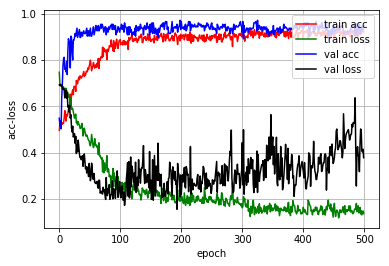

In [6]:
history.loss_plot('epoch')
plot_model(model, to_file='./model.png', show_shapes=True)

In [58]:
from keras.preprocessing import image
path_s = "/home/shuofeng/AIProject/FaceBC/data/test/genderdata1/"
#     path_s = "data/train/person_x/"
num = 1
path = path_s+str(num) + ".bmp"
image_train = np.zeros((1,116,96,3)) 
imgt = image.load_img(path, target_size = (116,96))
x = image.img_to_array(imgt)
gray = rgb2gray(x)
gray = x.reshape((116,96,3))         
image = gray.reshape(1,image_test.shape[0],image_test.shape[1],3)  
# image = image / 255.  
# imaget = tf.image.convert_image_dtype(image, tf.float32)  
print("image shape: %", str(image.shape)) 
res = model.predict(image)
print("res:",str(res))


('image shape: %', '(1, 116, 96, 3)')
('res:', '[[0.9999999]]')


In [59]:
from keras.models import load_model
import tensorflow as tf
import os 
import os.path as osp
from keras import backend as K
# model = cnn_model()
# model = load_model('model/facegender.h5')
#路径参数
input_path = 'input path'
weight_file = 'facegender.h5'
weight_file_path = osp.join(input_path,weight_file)
output_graph_name = weight_file[:-3] + '.pb'
#转换函数
def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = K.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)
#输出路径
output_dir = osp.join(os.getcwd(),"trans_model")
#加载模型
# h5_model = load_model(weight_file_path)
h5_to_pb(model,output_dir = output_dir,model_name = output_graph_name)
print('model saved')

INFO:tensorflow:Froze 28 variables.
INFO:tensorflow:Converted 28 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=/home/shuofeng/AIProject/FaceBC/trans_model
model saved
